In [5]:
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
from utils import *
from train import fit, evaluate
import CNN, MLP
import medmnist
from medmnist import INFO

## We work on the 2D dataset with size 28x28

In [6]:
data_flag = 'bloodmnist'
download = True
BATCH_SIZE = 128

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

## First, we read the MedMNIST data, preprocess them and encapsulate them into dataloader form.

In [7]:
# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)
validation_dataset = DataClass(split='val', transform=data_transform, download=download)

write_log('train_dataset_log.txt', str(train_dataset))
write_log('test_dataset_log.txt', str(test_dataset))
write_log('validation_dataset_log.txt', str(validation_dataset))

pil_dataset = DataClass(split='train', download=download)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
validation_loader = data.DataLoader(dataset=validation_dataset, batch_size=2*BATCH_SIZE, shuffle=False)


Train: torch.Size([11959, 2352]), Test: torch.Size([3421, 2352])
Epoch [1/1], Loss: 0.2622
Training Accuracy: 32.00%
Epoch [1/15] - Test Loss: 0.0853, Test Acc: 45.05%, F1: 0.3669
Epoch [1/1], Loss: 0.0792
Training Accuracy: 55.31%
Epoch [2/15] - Test Loss: 0.0736, Test Acc: 59.57%, F1: 0.5211
Epoch [1/1], Loss: 0.0711
Training Accuracy: 63.53%
Epoch [3/15] - Test Loss: 0.0694, Test Acc: 66.24%, F1: 0.6083
Epoch [1/1], Loss: 0.0677
Training Accuracy: 67.26%
Epoch [4/15] - Test Loss: 0.0667, Test Acc: 66.79%, F1: 0.6167
Epoch [1/1], Loss: 0.0641
Training Accuracy: 68.97%
Epoch [5/15] - Test Loss: 0.0630, Test Acc: 67.64%, F1: 0.6285
Epoch [1/1], Loss: 0.0608
Training Accuracy: 70.02%
Epoch [6/15] - Test Loss: 0.0593, Test Acc: 69.51%, F1: 0.6530
Epoch [1/1], Loss: 0.0581
Training Accuracy: 70.84%
Epoch [7/15] - Test Loss: 0.0565, Test Acc: 70.07%, F1: 0.6617
Epoch [1/1], Loss: 0.0560
Training Accuracy: 71.66%
Epoch [8/15] - Test Loss: 0.0548, Test Acc: 71.12%, F1: 0.6751
Epoch [1/1], Lo

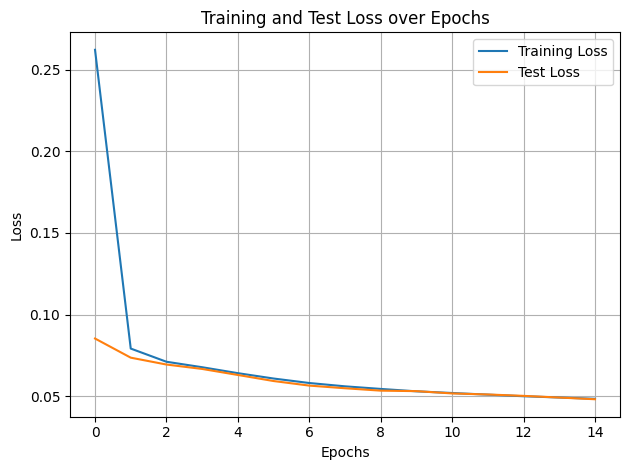

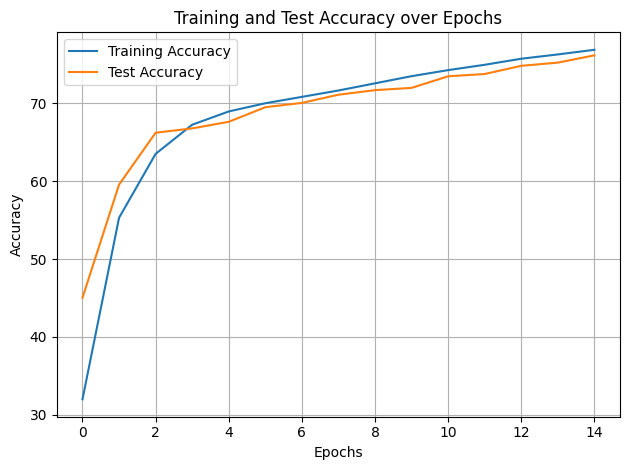

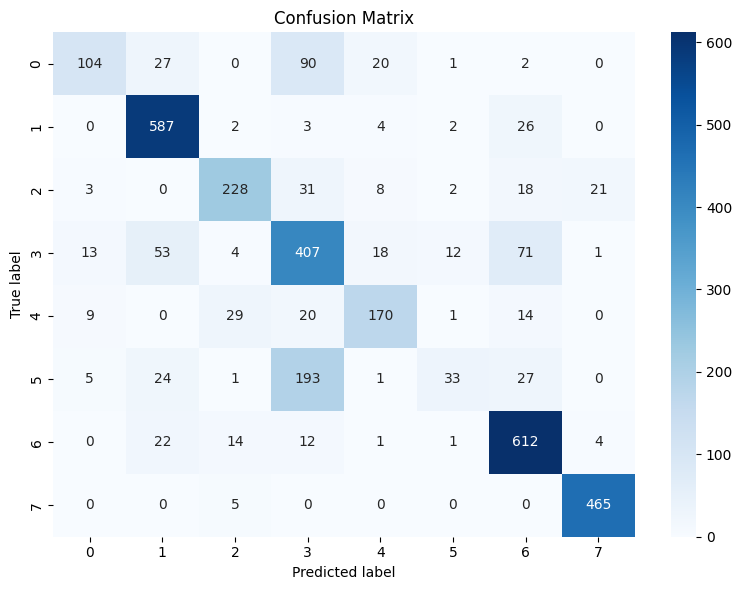

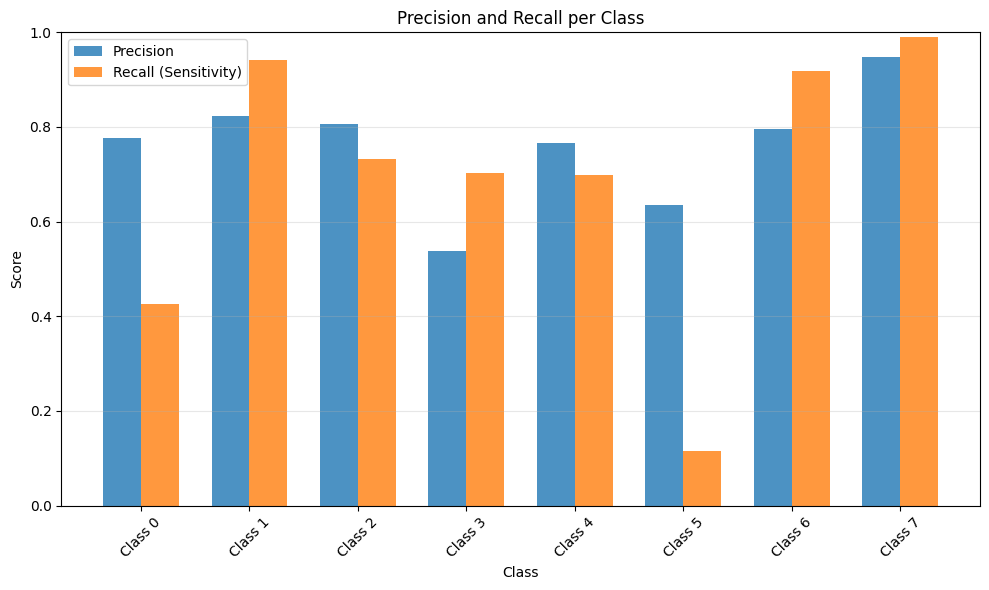

In [8]:
# variables declaration
model_type = "MLNN"
n_epochs = 15
n_layers = 1
n_inputs = n_channels * 28 * 28
size_hidden_layer = (n_inputs + n_classes) // 2  # n_classes = n_outputs
#loss_function = nn.CrossEntropyLoss()
loss_function = nn.MSELoss()
learning_rate = 0.001


device = get_device()

assert device is not None

write_log("main_log.txt", f"Using device: {device}\n")

assert model_type is not None

if model_type == "CNN":
    # create model
    model = CNN.CNN(n_channels, n_classes)
    #optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

    X_train, y_train = process_data(train_loader, flag=False)
    X_test, y_test = process_data(test_loader, flag=False)

    # train and evaluate per epoch
    training_losses = []
    training_accs = []
    test_losses = []
    test_accs = []
    test_f1s = []

    for epoch in range(n_epochs):
        # train one epoch
        epoch_losses, epoch_accs, model = fit(
            device,
            X_train,
            y_train,
            model,
            loss_function,
            optimizer,
            n_epochs=1,
            batch_size=BATCH_SIZE,
        )
        training_losses.extend(epoch_losses)
        training_accs.extend(epoch_accs)

        # evaluate on test set
        CM_test, f1_test, loss_test, acc_test = evaluate(
            device, X_test, y_test, model, loss_function
        )
        test_losses.append(loss_test)
        test_accs.append(acc_test)
        test_f1s.append(f1_test)

        print(
            f"Epoch [{epoch+1}/{n_epochs}] - Test Loss: {loss_test:.4f}, Test Acc: {acc_test:.2f}%, F1: {f1_test:.4f}"
        )

    trained_model = model

    # final confusion matrix and metrics
    CM, f1, final_test_loss, final_test_acc = evaluate(
        device, X_test, y_test, trained_model, loss_function
    )

    precision, sensitivity, specificity = get_metrics(CM)
    complexity = sum(p.numel() for p in trained_model.parameters() if p.requires_grad)

    # calculate macro averages
    macro_precision = np.mean(precision)
    macro_sensitivity = np.mean(sensitivity)
    macro_specificity = np.mean(specificity)

    # save results
    write_log(
        "training_history.txt",
        f"Training Losses: {training_losses}\n"
        f"Training Accuracies: {training_accs}\n"
        f"Test Losses: {test_losses}\n"
        f"Test Accuracies: {test_accs}\n"
        f"Test F1 Scores: {test_f1s}\n",
    )

    write_log(
        "final_results.txt",
        f"Final Confusion Matrix:\n{CM}\n"
        f"F1 Score: {f1:.4f}\n"
        f"Test Loss: {final_test_loss:.4f}\n"
        f"Test Accuracy: {final_test_acc:.2f}%\n"
        f"Complexity: {complexity:,} parameters\n"
        f"Macro Precision: {macro_precision:.4f}\n"
        f"Macro Sensitivity: {macro_sensitivity:.4f}\n"
        f"Macro Specificity: {macro_specificity:.4f}\n",
    )

    # Plot comparisons
    plot_loss(training_losses, test_losses)
    plot_acc(training_accs, test_accs)
    plot_confusion_matrix(CM, n_classes)
    plot_precision_recall(precision, sensitivity, n_classes)

    print(f"\nFinal Results:")
    print(f"Test Loss: {final_test_loss:.4f}, Test Acc: {final_test_acc:.2f}%")
    print(f"F1 Score: {f1:.4f}")
    print(f"Complexity: {complexity:,} parameters")
    print(f"Macro Precision: {macro_precision:.4f}")
    print(f"Macro Sensitivity: {macro_sensitivity:.4f}")
    print(f"Macro Specificity: {macro_specificity:.4f}")


elif model_type == "MLNN":
    model = MLP.MLP(n_inputs, [size_hidden_layer] * n_layers, n_classes, 0.2)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    # optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

    # process data
    X_train, y_train = process_data(train_loader)
    X_test, y_test = process_data(test_loader)

    print(f"Train: {X_train.shape}, Test: {X_test.shape}")
    write_log(
        "main_log.txt",
        f"Processed data shapes: Train: {X_train.shape}, Test: {X_test.shape}\n",
    )

    # train and evaluate per epoch
    training_losses = []
    training_accs = []
    test_losses = []
    test_accs = []
    test_f1s = []

    for epoch in range(n_epochs):
        # train one epoch
        epoch_losses, epoch_accs, model = fit(
            device,
            X_train,
            y_train,
            model,
            loss_function,
            optimizer,
            n_epochs=1,
            batch_size=BATCH_SIZE,
        )
        training_losses.extend(epoch_losses)
        training_accs.extend(epoch_accs)

        # evaluate on test set
        CM_test, f1_test, loss_test, acc_test = evaluate(
            device, X_test, y_test, model, loss_function
        )
        test_losses.append(loss_test)
        test_accs.append(acc_test)
        test_f1s.append(f1_test)

        print(
            f"Epoch [{epoch+1}/{n_epochs}] - Test Loss: {loss_test:.4f}, Test Acc: {acc_test:.2f}%, F1: {f1_test:.4f}"
        )

    trained_model = model

    # final confusion matrix and metrics
    CM, f1, final_test_loss, final_test_acc = evaluate(
        device, X_test, y_test, trained_model, loss_function
    )

    precision, sensitivity, specificity = get_metrics(CM)
    complexity = sum(p.numel() for p in trained_model.parameters() if p.requires_grad)

    # calculate macro averages
    macro_precision = np.mean(precision)
    macro_sensitivity = np.mean(sensitivity)
    macro_specificity = np.mean(specificity)

    # save results
    write_log(
        "training_history.txt",
        f"Training Losses: {training_losses}\n"
        f"Training Accuracies: {training_accs}\n"
        f"Test Losses: {test_losses}\n"
        f"Test Accuracies: {test_accs}\n"
        f"Test F1 Scores: {test_f1s}\n",
    )

    write_log(
        "final_results.txt",
        f"Final Confusion Matrix:\n{CM}\n"
        f"F1 Score: {f1:.4f}\n"
        f"Test Loss: {final_test_loss:.4f}\n"
        f"Test Accuracy: {final_test_acc:.2f}%\n"
        f"Complexity: {complexity:,} parameters\n"
        f"Macro Precision: {macro_precision:.4f}\n"
        f"Macro Sensitivity: {macro_sensitivity:.4f}\n"
        f"Macro Specificity: {macro_specificity:.4f}\n",
    )

    # plot comparisons
    plot_loss(training_losses, test_losses)
    plot_acc(training_accs, test_accs)
    plot_confusion_matrix(CM, n_classes)
    plot_precision_recall(precision, sensitivity, n_classes)

    print(f"\nFinal Results:")
    print(f"Test Loss: {final_test_loss:.4f}, Test Acc: {final_test_acc:.2f}%")
    print(f"F1 Score: {f1:.4f}")
    print(f"Complexity: {complexity:,} parameters")
    print(f"Macro Precision: {macro_precision:.4f}")
    print(f"Macro Sensitivity: {macro_sensitivity:.4f}")
    print(f"Macro Specificity: {macro_specificity:.4f}")